In [1]:
import sys
import os
import math
import random
import heapq 
import time
import copy
import gc
import numpy as np
import pandas as pd
from functools import reduce
from scipy.spatial.distance import pdist
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import faiss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
#Read data with List storage N:[name],I:[img],Y[type]
image_dir = '/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New' #the path of images
trainset = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_MICCAI_train.csv" , sep=',')#load dataset
testset = pd.read_csv("/data/fjsdata/ASOCT/Cataract/CBIR_MICCAI_test.csv" , sep=',')#load testset

#read train image with CV
trN, trI, trY = [],[],[]
for iname, itype in np.array(trainset).tolist():#column: name,id,lr,N,C,P  
    if iname.endswith(".jpg"):
        try:
            image_path = os.path.join(image_dir, iname)
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (512, 512))
            trN.append(iname)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trN),len(trainset)))
        sys.stdout.flush()
print('The length of train set is %d'%len(trN))
#read test image with CV
teN, teI, teY = [],[],[]
for iname, itype in np.array(testset).tolist():#column: name,id,lr,N,C,P  
    if iname.endswith(".jpg"):
        try:
            image_path = os.path.join(image_dir, iname)
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (512, 512))
            teN.append(iname)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teN),len(testset)))
        sys.stdout.flush()
print('The length of train set is %d'%len(teN))

#Generate image pairs for model
def onlineGenImgPairs(spls=len(trY)):
    idx_sf = random.sample(range(0, len(trY)),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf
trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()

468 / 7000 C020_20180514_100234_R_CASIA2_LGC_004.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_004.jpg
568 / 7000 C020_20180514_100234_R_CASIA2_LGC_000.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_000.jpg
1871 / 7000 C020_20180514_100234_R_CASIA2_LGC_002.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_002.jpg
1929 / 7000 C020_20180514_100234_R_CASIA2_LGC_008.jpg:/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/C020_20180514_100234_R_CASIA2_LGC_008.jpg
6996 / 7000 The length of train set is 6996
700 / 700 The length of train set is 700


In [4]:
#feature map 
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ASHNet(nn.Module): #deep Hashint Network:DHNet
    def __init__(self,inChannels=3,outHashcode=16):
        super(ASHNet, self).__init__()
        #(channels, Height, Width)
        #layer1: Convolution, (3,512,512)->(16,256,256)
        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        #layer2: max pooling,(16,256,256)->(16,128,128)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        #layer3: Channel and Spatial Attention Layer, (8,256,256)->(8,256,256)
        self.sa = SpatialAttention()
        #layer4: Convolution, (16,128,128)->(32,64,64)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        #layer5: mean pooling, (32,64,64)->(32,32,32)
        self.avgpool = nn.AvgPool2d(kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(32)
        #layer6: fully connected, 32*32*32->4096
        self.fcl1 = nn.Linear(32*32*32,4096)
        self.relu3 = nn.ReLU(inplace=True)
        #layer7: Hashing layer, 4096->16
        self.fcl2 = nn.Linear(4096,outHashcode)
              
    def forward(self,x):
        #input: (batch_size, in_channels, Height, Width)
        #output: (batch_size, out_channels, Height, Width)
        #layer1: convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        #layer2: max pooling
        x = self.maxpool(x)
        x = self.bn2(x)
        #layer3: Attention
        x = self.sa(x) * x  #spatial
        #layer4: Convolution
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu2(x)
        #layer5: mean pooling
        x = self.avgpool(x)
        x = self.bn4(x)
        #layer6:fully connected layer
        x = x.view(x.size(0),-1) #transfer three dims to one dim
        x = self.fcl1(x)
        x = self.relu3(x)
        #layer7: Hashing layer
        x = self.fcl2(x)
                
        return x
    
#https://pytorch-cn.readthedocs.io/zh/latest/    
#https://github.com/filipradenovic/cnnimageretrieval-pytorch/blob/master/cirtorch/layers/functional.py
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = ASHNet(outHashcode=12).cuda()#[12,24,36,48]
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    #trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()

 350 / 350 : loss = 0.846363Eopch:     1 mean_loss = 1.545692
 350 / 350 : loss = 0.826278Eopch:     2 mean_loss = 1.701681
 350 / 350 : loss = 1.076112Eopch:     3 mean_loss = 1.381147
 350 / 350 : loss = 0.398561Eopch:     4 mean_loss = 1.198362
 350 / 350 : loss = 0.302102Eopch:     5 mean_loss = 1.000142
 350 / 350 : loss = 0.316908Eopch:     6 mean_loss = 0.795601
 350 / 350 : loss = 0.058468Eopch:     7 mean_loss = 0.625642
 350 / 350 : loss = 0.243675Eopch:     8 mean_loss = 0.456123
 350 / 350 : loss = 0.127541Eopch:     9 mean_loss = 0.424429
 350 / 350 : loss = 0.099755Eopch:    10 mean_loss = 0.344007
best_loss = 0.344007


In [79]:
print(teY[500])

3.0


3.0


(-0.5, 383.5, 1131.5, -0.5)

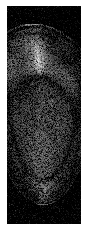

In [99]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

#original
print(teY[500])
image_path = os.path.join(image_dir, teN[500])
#img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
oriImg = cv2.imread(image_path)
#oriImg = normalize_output(oriImg)
#oriImg = cv2.applyColorMap(oriImg, cv2.COLORMAP_JET)
plt.imshow(oriImg)
plt.axis('off')

(-0.5, 383.5, 1131.5, -0.5)

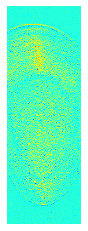

In [100]:
#train
data_5 = torch.from_numpy(np.array(teI[500:501])).type(torch.FloatTensor).cuda()
output = best_net(data_5.permute(0, 3, 1, 2))#forword
#conv1         
best_net.conv1.register_forward_hook(get_activation('conv1'))#maxpool
feature = activation['conv1'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width, _ = oriImg.shape
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
#featuremap = featuremap * 0.3 + oriImg * 0.5
plt.imshow(featuremap)
plt.axis('off')

(-0.5, 383.5, 1131.5, -0.5)

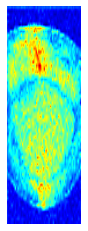

In [101]:
#conv2         
best_net.conv2.register_forward_hook(get_activation('conv2'))#maxpool
feature = activation['conv2'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
height, width, _ = oriImg.shape
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
plt.imshow(featuremap)
plt.axis('off')

In [6]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ASHNet(nn.Module): #deep Hashint Network:DHNet
    def __init__(self,inChannels=3,outHashcode=16):
        super(ASHNet, self).__init__()
        #(channels, Height, Width)
        #layer1: Convolution, (3,512,512)->(16,256,256)
        self.conv1 = nn.Conv2d(in_channels=inChannels, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        #layer2: max pooling,(16,256,256)->(16,128,128)
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        #layer3: Channel and Spatial Attention Layer, (8,256,256)->(8,256,256)
        self.sa = SpatialAttention()
        #layer4: Convolution, (16,128,128)->(32,64,64)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        #layer5: mean pooling, (32,64,64)->(32,32,32)
        self.avgpool = nn.AvgPool2d(kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(32)
        #layer6: fully connected, 32*32*32->4096
        self.fcl1 = nn.Linear(32*32*32,4096)
        self.relu3 = nn.ReLU(inplace=True)
        #layer7: Hashing layer, 4096->16
        self.fcl2 = nn.Linear(4096,outHashcode)
              
    def forward(self,x):
        #input: (batch_size, in_channels, Height, Width)
        #output: (batch_size, out_channels, Height, Width)
        #layer1: convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        #layer2: max pooling
        x = self.maxpool(x)
        x = self.bn2(x)
        #layer3: Attention
        x = self.sa(x) * x  #spatial
        #layer4: Convolution
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu2(x)
        #layer5: mean pooling
        x = self.avgpool(x)
        x = self.bn4(x)
        #layer6:fully connected layer
        x = x.view(x.size(0),-1) #transfer three dims to one dim
        x = self.fcl1(x)
        x = self.relu3(x)
        #layer7: Hashing layer
        x = self.fcl2(x)
                
        return x
    
#https://pytorch-cn.readthedocs.io/zh/latest/    
#https://github.com/filipradenovic/cnnimageretrieval-pytorch/blob/master/cirtorch/layers/functional.py
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = ASHNet(outHashcode=12).cuda()#[12,24,36,48]
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    #trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize + 1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 350 / 350 : loss = 9.403307877Eopch:     1 mean_loss = 14.718902
 350 / 350 : loss = 1.41615191Eopch:     2 mean_loss = 10.866790
 350 / 350 : loss = 1.537777265Eopch:     3 mean_loss = 28.862989
 350 / 350 : loss = 1.14367967Eopch:     4 mean_loss = 7.201795
 350 / 350 : loss = 0.945247545Eopch:     5 mean_loss = 12.187805
 350 / 350 : loss = 1.0595946Eopch:     6 mean_loss = 2.051383
 350 / 350 : loss = 0.8560882Eopch:     7 mean_loss = 1.168658
 350 / 350 : loss = 0.840941Eopch:     8 mean_loss = 0.949327
 350 / 350 : loss = 0.853996Eopch:     9 mean_loss = 0.873808
 350 / 350 : loss = 0.712698Eopch:    10 mean_loss = 0.809745
best_loss = 0.809745
 69 / 70 0 mHR@10=0.730857, mAP@10=0.914690, mRR@10=0.935436


In [14]:
itype = teY[699]
teVal = teF[699]
image_path = os.path.join(image_dir, teN[699])
map_item_score = {}
for j, trVal in enumerate(trF):
    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
ranklist = heapq.nsmallest(5, map_item_score, key=map_item_score.get)
image_path_top = []
for j in ranklist:
    print ('type:%d'%trY[j])
    image_path_top.append(trN[j])
print (image_path)
print(image_path_top)

type:5
type:5
type:5
type:5
type:5
/data/fjsdata/ASOCT/Cataract/C_8bit_Crop_New/c0467_20181225_152240_R_CASIA2_LGC_012.jpg
['c0467_20181225_152240_R_CASIA2_LGC_014.jpg', 'c0467_20181225_152240_R_CASIA2_LGC_022.jpg', 'c0467_20181225_152240_R_CASIA2_LGC_018.jpg', 'c0467_20181225_152240_R_CASIA2_LGC_016.jpg', 'c0467_20181225_152240_R_CASIA2_LGC_028.jpg']


In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        )
        self.linear_input_size = 16*256*256
        self.linear = nn.Linear(self.linear_input_size, num_classes)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, self.linear_input_size)
        return self.linear(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class DRH(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        resnet = ResNet(num_classes=10)
        resnet.linear = nn.Linear(in_features=resnet.linear_input_size, out_features=code_size)
        self.net = resnet

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        return self.net(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = DRH(code_size=12).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize +1
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize+1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 350 / 350 : loss = 1.708946Eopch:     1 mean_loss = 2.342225
 350 / 350 : loss = 0.869617Eopch:     2 mean_loss = 1.264071
 350 / 350 : loss = 0.118889Eopch:     3 mean_loss = 0.530928
 350 / 350 : loss = 0.114707Eopch:     4 mean_loss = 0.228710
 350 / 350 : loss = 0.097965Eopch:     5 mean_loss = 0.175077
 350 / 350 : loss = 0.079824Eopch:     6 mean_loss = 0.173948
 350 / 350 : loss = 0.066339Eopch:     7 mean_loss = 0.169101
 350 / 350 : loss = 0.082063Eopch:     8 mean_loss = 0.156225
 350 / 350 : loss = 0.052895Eopch:     9 mean_loss = 0.136653
 350 / 350 : loss = 0.081121Eopch:    10 mean_loss = 0.146545
best_loss = 0.136653
 69 / 70 0 mHR@5=0.788571, mAP@5=0.740362, mRR@5=0.935065
mHR@10=0.728286, mAP@10=0.658054, mRR@10=0.927113
mHR@15=0.688667, mAP@15=0.604140, mRR@15=0.927113
mHR@20=0.655429, mAP@20=0.561593, mRR@20=0.927113


In [9]:
class DSH(nn.Module):
    def __init__(self, num_binary):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),  # same padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*63*63, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, num_binary)
        )

        for m in self.modules():
            if m.__class__ == nn.Conv2d or m.__class__ == nn.Linear:
                nn.init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = DSH(num_binary=12).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize +1
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize+1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

/root/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 350 / 350 : loss = 1.0379988Eopch:     1 mean_loss = 10.379202
 350 / 350 : loss = 1.067624Eopch:     2 mean_loss = 1.287073
 350 / 350 : loss = 1.464777Eopch:     3 mean_loss = 1.175607
 350 / 350 : loss = 0.874249Eopch:     4 mean_loss = 1.097566
 350 / 350 : loss = 0.624755Eopch:     5 mean_loss = 0.970758
 350 / 350 : loss = 0.491966Eopch:     6 mean_loss = 0.824108
 350 / 350 : loss = 0.665735Eopch:     7 mean_loss = 0.695405
 350 / 350 : loss = 0.516997Eopch:     8 mean_loss = 0.619425
 350 / 350 : loss = 0.302654Eopch:     9 mean_loss = 0.492237
 350 / 350 : loss = 0.449591Eopch:    10 mean_loss = 0.385107
best_loss = 0.385107
 69 / 70 0 mHR@5=0.374571, mAP@5=0.276476, mRR@5=0.702511
mHR@10=0.340000, mAP@10=0.213408, mRR@10=0.640314
mHR@15=0.324000, mAP@15=0.184949, mRR@15=0.620521
mHR@20=0.309786, mAP@20=0.165776, mRR@20=0.610795


In [10]:
class AlexNet(nn.Module):

    def __init__(self, code_length):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            #nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )

        self.classifier = self.classifier[:-1]
        self.hash_layer = nn.Linear(4096, code_length)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = self.hash_layer(x)
        return x
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = AlexNet(code_length=12).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize +1
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize+1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 350 / 350 : loss = 24.766958Eopch:     1 mean_loss = 5.495191
 350 / 350 : loss = 2.2251592Eopch:     2 mean_loss = 2.204870
 350 / 350 : loss = 2.6306182Eopch:     3 mean_loss = 2.408939
 350 / 350 : loss = 3.4334781Eopch:     4 mean_loss = 2.490089
 350 / 350 : loss = 3.5877544Eopch:     5 mean_loss = 2.035738
 350 / 350 : loss = 2.2677659Eopch:     6 mean_loss = 2.166109
 350 / 350 : loss = 1.2672231Eopch:     7 mean_loss = 2.306979
 350 / 350 : loss = 2.2625594Eopch:     8 mean_loss = 2.451464
 350 / 350 : loss = 2.2756297Eopch:     9 mean_loss = 2.245329
 350 / 350 : loss = 1.683848Eopch:    10 mean_loss = 1.646907
best_loss = 1.646907
 69 / 70 0 mHR@5=0.246571, mAP@5=0.149867, mRR@5=0.564023
mHR@10=0.245857, mAP@10=0.120899, mRR@10=0.476284
mHR@15=0.240857, mAP@15=0.106031, mRR@15=0.454857
mHR@20=0.239214, mAP@20=0.097620, mRR@20=0.444947


In [11]:
from sklearn.neighbors import LSHForest
trI_lsh = np.array(trI).reshape(len(trI),-1)
teI_lsh = np.array(teI).reshape(len(teI),-1)
# n_candidates in [12,24,32,48]:
lshf = LSHForest(min_hash_match=2, n_neighbors=20, n_candidates=12, n_estimators =10, random_state=42) #hashcode=32
lshf.fit(trI_lsh)  
for topk in [5,10,15,20]:
    distances, indices = lshf.kneighbors(teI_lsh, n_neighbors=topk)
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i in range(len(teY)):
        stype = teY[i]
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in indices[i]:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

/root/miniconda3/lib/python3.7/site-packages/sklearn/neighbors/approximate.py:258: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


mHR@10=0.326571, mAP@10=0.230001, mRR@10=0.738254


In [12]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHResNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        self.sa = SpatialAttention() 
        #fully connected
        self.linear = nn.Linear(16*256*256, code_size)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    
class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#define model
model = ASHResNet(code_size=12).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss = loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#train data with list: trI, trF, trY
#test data with list: teI, teF, teY
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i, teVal in enumerate(teF):
        stype = teY[i]
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')
        ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in ranklist:
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

 349 / 349 : loss = 1.618136Eopch:     1 mean_loss = 1.224363
 349 / 349 : loss = 1.196813Eopch:     2 mean_loss = 1.305192
 349 / 349 : loss = 0.395359Eopch:     3 mean_loss = 0.573466
 349 / 349 : loss = 0.134902Eopch:     4 mean_loss = 0.151089
 349 / 349 : loss = 0.125273Eopch:     5 mean_loss = 0.103151
 349 / 349 : loss = 0.108394Eopch:     6 mean_loss = 0.084867
 349 / 349 : loss = 0.177682Eopch:     7 mean_loss = 0.081601
 349 / 349 : loss = 0.147549Eopch:     8 mean_loss = 0.083191
 349 / 349 : loss = 0.097715Eopch:     9 mean_loss = 0.087857
 349 / 349 : loss = 0.114528Eopch:    10 mean_loss = 0.097251
best_loss = 0.081601
 69 / 70 9 mHR@5=0.672000, mAP@5=0.607071, mRR@5=0.886746
mHR@10=0.617429, mAP@10=0.521237, mRR@10=0.863992
mHR@15=0.572476, mAP@15=0.463275, mRR@15=0.858329
mHR@20=0.543143, mAP@20=0.423007, mRR@20=0.854884
